In [1]:
import hashlib as hl
import numpy as np
import pandas as pd
import string
import re
import seaborn as sns
import holidays
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import STL

import jax.numpy as jnp
import numpyro

from ydata_profiling import ProfileReport

from lightweight_mmm import lightweight_mmm, optimize_media, plot, preprocessing, utils
import utils.utils_mmm as utils


**PLEASE NOTE:** All data contained in this and subsequent notebooks is anonymized data that have been derived from a real-world dataset.

## LightweightMMM

### Model Specification
The specification for the LightweightMMM model is defined as:

<!-- Model Specification -->
<span style="font-weight: 800; font-size: 25px;">
<math  display='block'>
  <mi>k</mi>
  <mi>p</mi>
  <msub>
    <mi>i</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
    </mrow>
  </msub>
  <mo>=</mo>
  <mi>&#x3B1;</mi>
  <mo>+</mo>
  <mi>t</mi>
  <mi>r</mi>
  <mi>e</mi>
  <mi>n</mi>
  <msub>
    <mi>d</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
    </mrow>
  </msub>
  <mo>+</mo>
  <mi>s</mi>
  <mi>e</mi>
  <mi>a</mi>
  <mi>s</mi>
  <mi>o</mi>
  <mi>n</mi>
  <mi>a</mi>
  <mi>l</mi>
  <mi>i</mi>
  <mi>t</mi>
  <msub>
    <mi>y</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
    </mrow>
  </msub>
  <mo>+</mo>
  <mi>m</mi>
  <mi>e</mi>
  <mi>d</mi>
  <mi>i</mi>
  <mi>a</mi>
  <mtext>&#xA0;</mtext>
  <mi>c</mi>
  <mi>h</mi>
  <mi>a</mi>
  <mi>n</mi>
  <mi>n</mi>
  <mi>e</mi>
  <mi>l</mi>
  <msub>
    <mi>s</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
    </mrow>
  </msub>
  <mo>+</mo>
  <mi>o</mi>
  <mi>t</mi>
  <mi>h</mi>
  <mi>e</mi>
  <mi>r</mi>
  <mtext>&#xA0;</mtext>
  <mi>f</mi>
  <mi>a</mi>
  <mi>c</mi>
  <mi>t</mi>
  <mi>o</mi>
  <mi>r</mi>
  <msub>
    <mi>s</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
    </mrow>
  </msub>
</math>
</span>
<br>
<!-- Response -->
<span style="font-weight: 800;font-size: 20px;">
<math>
  <mi>k</mi>
  <mi>p</mi>
  <msub>
    <mi>i</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
    </mrow>
  </msub>
</math></span> = This is our target or response variable.  In our case study, the target variable is the annualized premium amount.
<br>
<!-- Intercept -->
<span style="font-weight: 800;font-size: 20px;">
<math>
  <mi>&#x3B1;</mi>
</math></span> = The intercept or baseline value of the target variable.  When all other explanatory variables are zero, this is the expected value for the annualized premium amount.
<!-- Trend -->
<br>
<span style="font-weight: 800;font-size: 20px;">
<math>
  <mi>t</mi>
  <mi>r</mi>
  <mi>e</mi>
  <mi>n</mi>
  <msub>
    <mi>d</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
    </mrow>
  </msub>
</math></span> = Increasing or decreasing trend of the target variable over time.
<!-- Seasonality -->
<br>
<span style="font-weight: 800;font-size: 20px;">
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>s</mi>
  <mi>e</mi>
  <mi>a</mi>
  <mi>s</mi>
  <mi>o</mi>
  <mi>n</mi>
  <mi>a</mi>
  <mi>l</mi>
  <mi>i</mi>
  <mi>t</mi>
  <msub>
    <mi>y</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
    </mrow>
  </msub> 
</math></span> = Periodic fluctations in the target variable (e.g., Due to holidays, other recurring events such as sales, etc.). LightweightMMM accounts for seasonality natively in the model.
<!-- Media Channels -->
<br>
<span style="font-weight: 800;font-size: 20px;">
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>m</mi>
  <mi>e</mi>
  <mi>d</mi>
  <mi>i</mi>
  <mi>a</mi>
  <mtext>&#xA0;</mtext>
  <mi>c</mi>
  <mi>h</mi>
  <mi>a</mi>
  <mi>n</mi>
  <mi>n</mi>
  <mi>e</mi>
  <mi>l</mi>
  <msub>
    <mi>s</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
    </mrow>
  </msub>
</math></span> = Accounts for the impact of media channels on the target.  In our case, TV, print, paid search, display media, and online video.
<br>
<span style="font-weight: 800;font-size: 20px;">
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>o</mi>
  <mi>t</mi>
  <mi>h</mi>
  <mi>e</mi>
  <mi>r</mi>
  <mtext>&#xA0;</mtext>
  <mi>f</mi>
  <mi>a</mi>
  <mi>c</mi>
  <mi>t</mi>
  <mi>o</mi>
  <mi>r</mi>
  <msub>
    <mi>s</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
    </mrow>
  </msub>
</math></span> = Any other factors that may influence the target variable (e.g., macro-economic indicators, industry-specific trends such as competitor performance, promotions and discounts etc.).

### Advertising AdStock
A deeper dive in the <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>m</mi>
  <mi>e</mi>
  <mi>d</mi>
  <mi>i</mi>
  <mi>a</mi>
  <mtext>&#xA0;</mtext>
  <mi>c</mi>
  <mi>h</mi>
  <mi>a</mi>
  <mi>n</mi>
  <mi>n</mi>
  <mi>e</mi>
  <mi>l</mi>
  <msub>
    <mi>s</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
    </mrow>
  </msub>
</math> component of the model is worthwhile.  More specifically, around the options for modeling [adstock](https://en.wikipedia.org/wiki/Advertising_adstock) that are provided by Lightweight MMM.  Adstock is a foundational concept in a marketing mix model. Essentially, it embodies the concepts of advertising decay and saturation. Decay refers to the idea that the impact of an ad on a consumer peaks at a certain point and gradually diminishes over time. On the other hand, the saturation aspect of adstock indicates that an escalation in advertising, such as an increase in advertising spending, eventually reaches a saturation point or inflection point. Beyond this point, additional spending yields diminishing returns. 

Lightweight MMM provides three models for incorporating adstock:

**Adstock**
The default model is simply referred to as "adstock," and it employs an infinite lag that diminishes its influence over time. This accommodates the delayed impact of advertising expenditure on sales (i.e., annualized premiums); for instance, individuals may make a purchase about a week after viewing a TV ad rather than on the same day. However, this default setting does not encompass saturation effects.

**Hill Adstock**
This model builds on the adstock model by adding additional parameters that account for the [saturation effect.](https://en.wikipedia.org/wiki/Advertising_adstock#:~:text=Advertising%20saturation%3A%20diminishing%20returns%20effect,-See%20also%3A%20Diminishing&text=Saturation%20only%20occurs%20above%20a,above%20110%20GRPs%20per%20week.) 

**Carryover Model**
The carryover model is simply a different way to model adstocks.

The full specifications for each of the adstock models can be found here: https://lightweight-mmm.readthedocs.io/en/latest/models.html

We will experiment with each of the three models for adstock.

### Prior Probabilities
Prior to proceeding, a final concept to underline is the notion of prior probabilities in the context of Bayesian statistics.

One of the key tenets of Bayesian statistics is the notion of incorporating prior knowledge (e.g., promotion effectiveness, sales trends, macro-economic factors etc.) into the model. LMMM provides both default priors and [custom priors](https://lightweight-mmm.readthedocs.io/en/latest/custom_priors.html?highlight=custom%20priors) as mechanisms for incorporating prior knowledge into the model.  <br>

For the case study, we will use the default priors provided.  However, in the case of operationalizing the model custom priors would be key to the marketing mix optimization strategy.

# Data Exploration

## Load Data

We begin by loading media data along with leads, policies and annualized premium data.

In [2]:
file_path = 'data/mmm_media.csv'
media_bi_df, media_mmm_df = utils.preprocess_media_data(file_path)

min_week = media_mmm_df.week_of.min()
max_week = media_mmm_df.week_of.max()

file_path = 'data/mmm_leads_policies.csv'
leads_bi_df, sales_bi_df, policies_mmm_df, premiums_mmm_df, leads_mmm_df = utils.preprocess_leads_policies_data(file_path, min_week, max_week)


In [3]:
# leads_bi_df['week_of'] = leads_bi_df['week_of'] + pd.DateOffset(years=7)
# sales_bi_df['week_of'] = sales_bi_df['week_of'] + pd.DateOffset(years=7)
# policies_mmm_df['week_of'] = policies_mmm_df['week_of'] + pd.DateOffset(years=7)
# premiums_mmm_df['week_of'] = premiums_mmm_df['week_of'] + pd.DateOffset(years=7)
# leads_mmm_df['week_of'] = leads_mmm_df['week_of'] + pd.DateOffset(years=7)
# media_mmm_df['week_of'] = media_mmm_df['week_of'] + pd.DateOffset(years=7)
# media_bi_df['week_of'] = media_bi_df['week_of'] + pd.DateOffset(years=7)
# holidays_mmm_df['week_of'] = holidays_mmm_df['week_of'] + pd.DateOffset(years=7)


## Media Cost vs. Annual Premiums

Let's start by comparing overall spend YoY

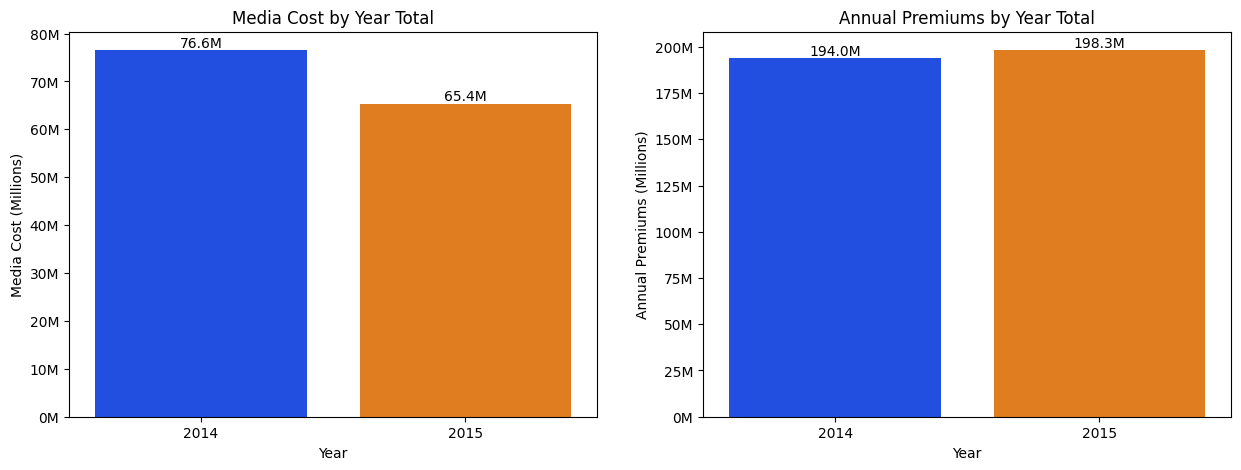

In [4]:
utils.plot_media_and_premiums_YoY(media_bi_df, premiums_mmm_df)

## Leads vs. Polices 

Leads vs Policies blah blah

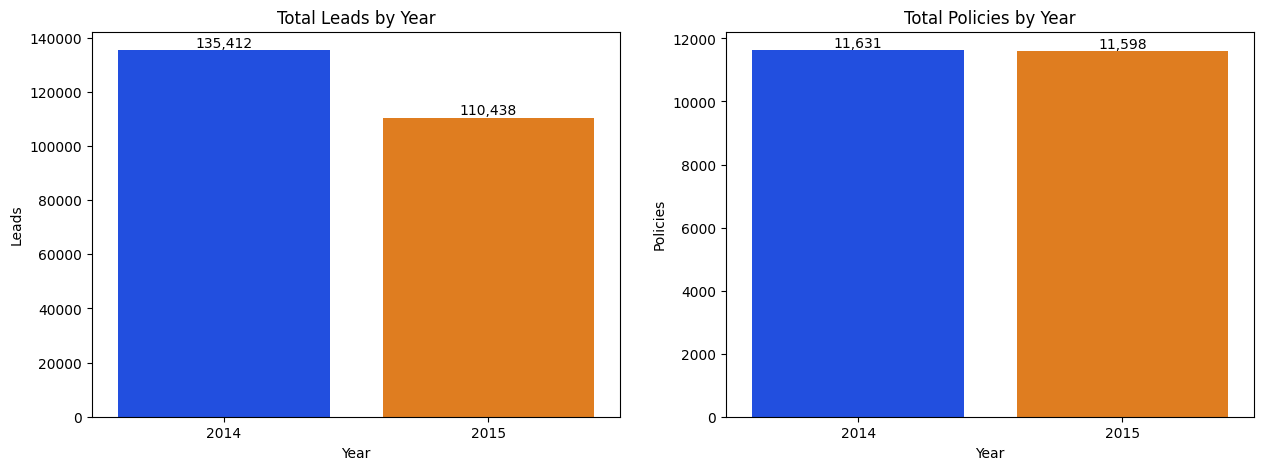

In [5]:
utils.plot_leads_and_policies_YoY(leads_mmm_df, policies_mmm_df)

## Conversion Rate and ROAS

Lorem ipsum blah blah

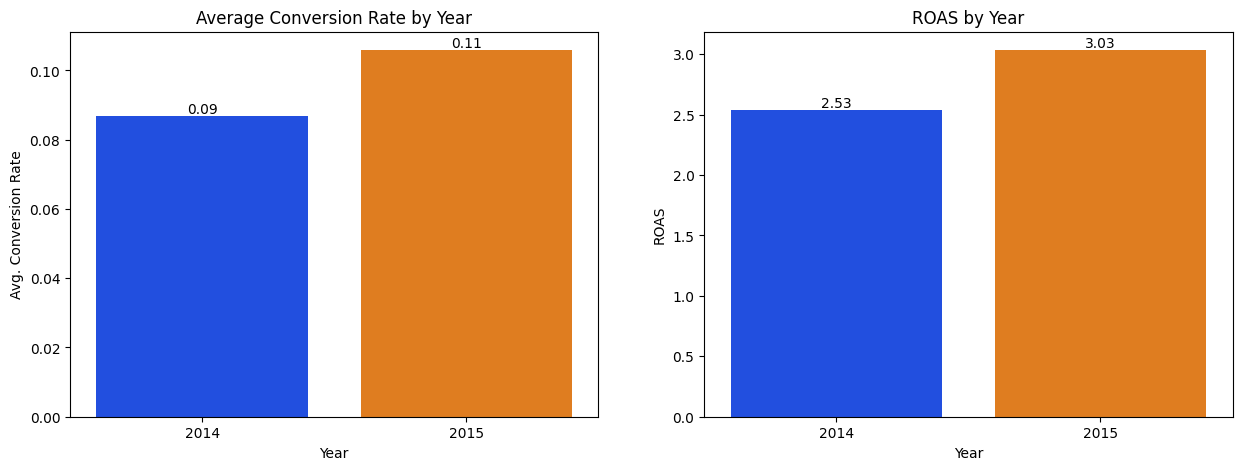

In [6]:
conv_rate_mmm_df = leads_mmm_df.merge(policies_mmm_df, on=['week_of'])
conv_rate_mmm_df['conv_rate'] = conv_rate_mmm_df['policies'] / conv_rate_mmm_df['leads']
conv_rate_mmm_df

utils.plot_conv_rate_and_roas_YoY(conv_rate_mmm_df, premiums_mmm_df, media_bi_df)

## Media Spend by Channel YoY

Lorem ipsum blah blah

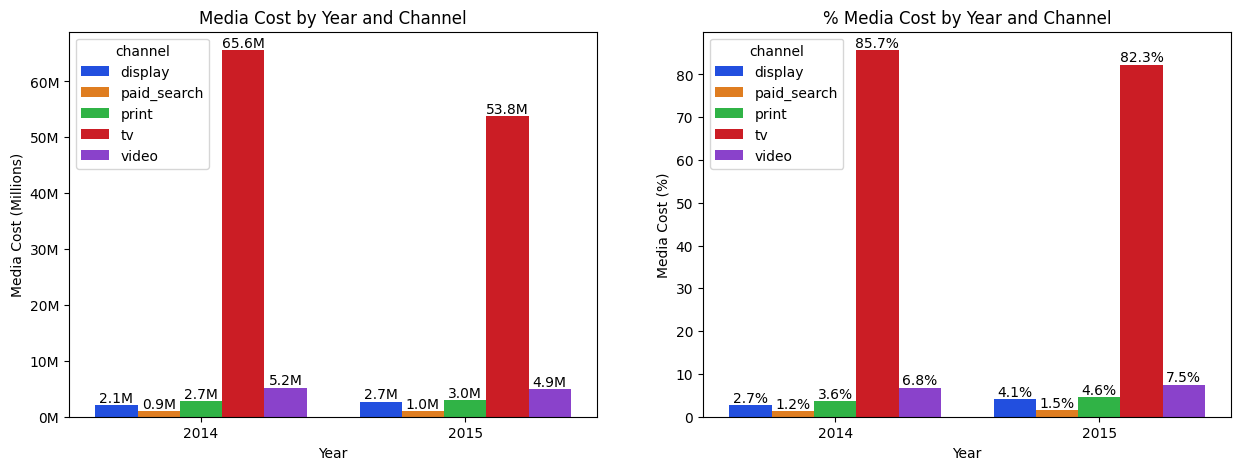

In [7]:
utils.plot_media_spend_by_channel_YoY(media_bi_df)

Select appropriate input variables to ensure variability.

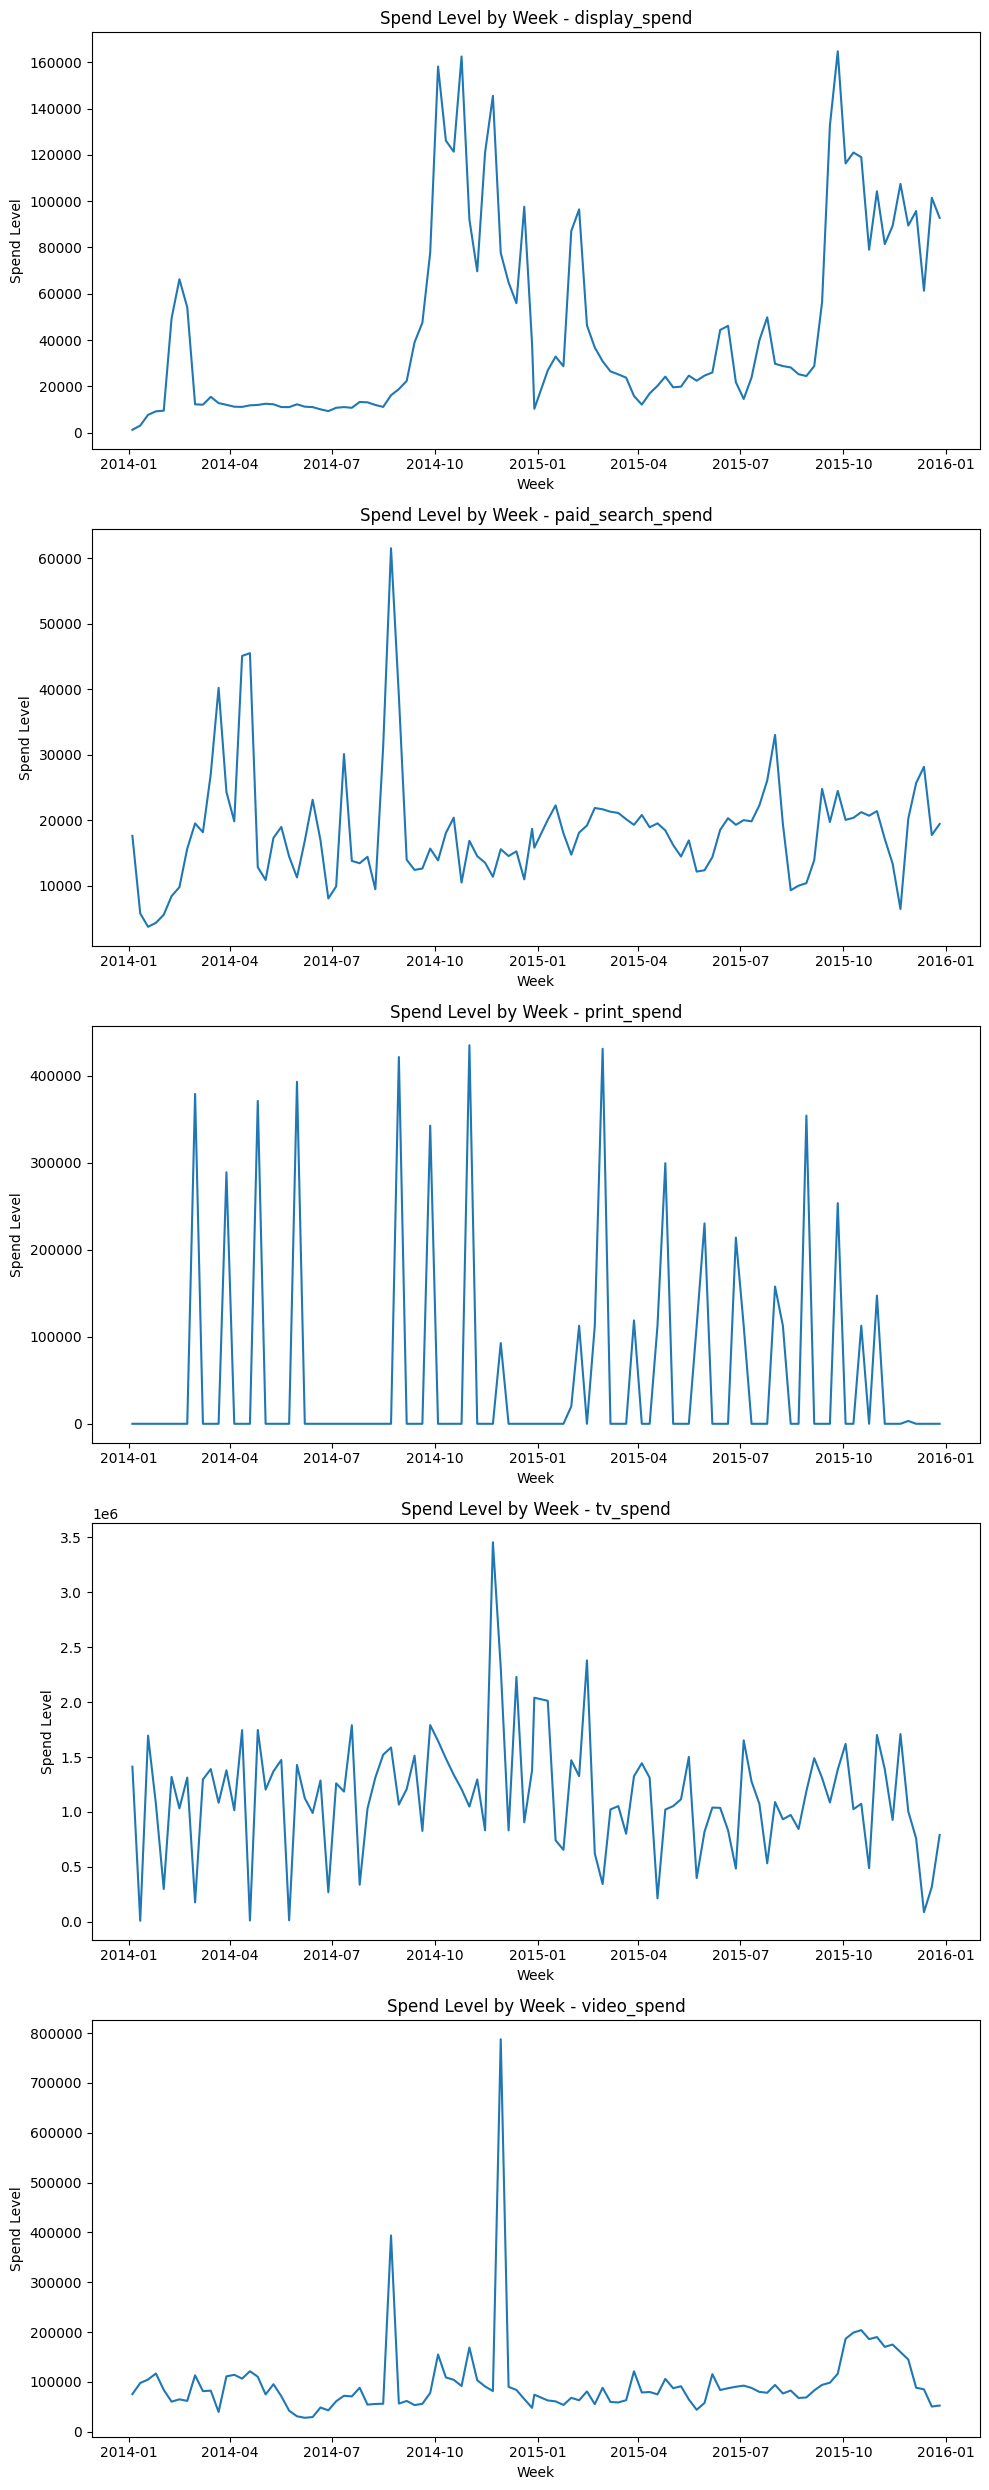

In [8]:
import seaborn as sns

# Import the required libraries
import matplotlib.pyplot as plt

media_spend_cols = [col for col in media_mmm_df.columns if 'spend' in col]

# Create a grid of line plots
fig, axes = plt.subplots(nrows=len(media_spend_cols), ncols=1, figsize=(10, 5*len(media_spend_cols)))

# Iterate over each channel and plot the spend level by week
for i, channel in enumerate(media_spend_cols):
    sns.lineplot(x='week_of', y=channel, data=media_mmm_df, ax=axes[i])
    axes[i].set_xlabel('Week')
    axes[i].set_ylabel('Spend Level')
    axes[i].set_title(f'Spend Level by Week - {channel}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## Encode holidays

In [9]:
holidays_bi_df, holidays_mmm_df = utils.get_holidays(media_mmm_df)

In [10]:
holidays_mmm_df

,week_of,holiday_christmas_day,holiday_columbus_day,holiday_independence_day,holiday_independence_day_observed,holiday_labor_day,holiday_martin_luther_king_jr_day,holiday_memorial_day,holiday_new_year_s_day,holiday_thanksgiving,holiday_veterans_day,holiday_washington_s_birthday
3,2014-01-04,0,0,0,0,0,0,0,1,0,0,0
0,2014-01-25,0,0,0,0,0,1,0,0,0,0,0
1,2014-02-22,0,0,0,0,0,0,0,0,0,0,1
4,2014-05-31,0,0,0,0,0,0,1,0,0,0,0
5,2014-07-05,0,0,1,0,0,0,0,0,0,0,0
6,2014-09-06,0,0,0,0,1,0,0,0,0,0,0
2,2014-10-18,0,1,0,0,0,0,0,0,0,0,0
7,2014-11-15,0,0,0,0,0,0,0,0,0,1,0
8,2014-11-29,0,0,0,0,0,0,0,0,1,0,0
9,2014-12-27,1,0,0,0,0,0,0,0,0,0,0


In [11]:
# Import required libraries
from statsmodels.tsa.stattools import adfuller, kpss

# Perform ADF test
result = adfuller(premiums_mmm_df['premium_annual'])
print('ADF test:\tp-value: {:.5f}'.format(result[1]))

ADF test:	p-value: 0.00000


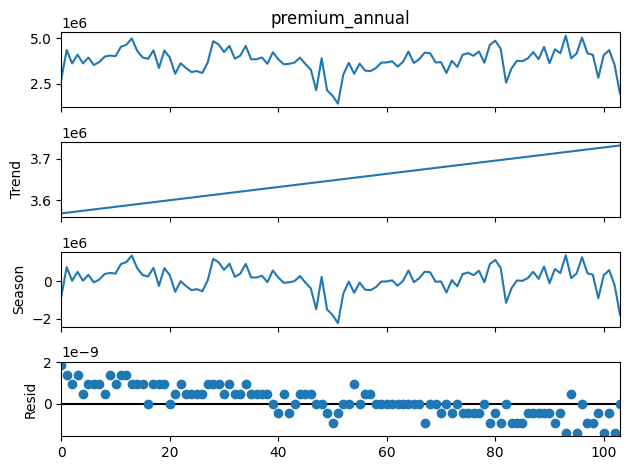

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


premiums_sd = STL(premiums_mmm_df['premium_annual'], seasonal=13, period=52).fit()

fig = premiums_sd.plot()

plt.savefig('img/premium_annual_decompose.png')


In [13]:
import statsmodels.api as sm

sm.stats.acorr_ljungbox(premiums_sd.resid, lags=[5], return_df=True)

,lb_stat,lb_pvalue
5,209.666347,2.425728e-43


In [14]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test:
print('Results of Augmented Dickey-Fuller Test:')
dftest = adfuller(premiums_mmm_df['premium_annual'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic                -5.817508e+00
p-value                        4.258345e-07
#Lags Used                     0.000000e+00
Number of Observations Used    1.030000e+02
Critical Value (1%)           -3.495493e+00
Critical Value (5%)           -2.890037e+00
Critical Value (10%)          -2.581971e+00
dtype: float64


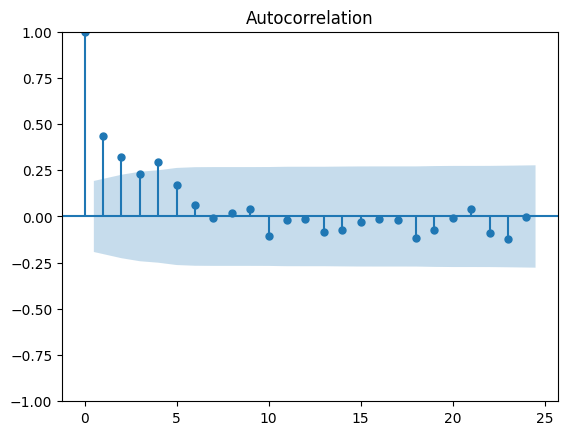

In [15]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(premiums_mmm_df['premium_annual'], lags=24)
pyplot.savefig('acf_plot.png')
pyplot.show()

# MMM Model

In [16]:
media_mmm_df

,week_of,display_spend,paid_search_spend,print_spend,tv_spend,video_spend
0,2014-01-04,1202.0,17642.29,0.0,1412418.0,75527.0
1,2014-01-11,3032.0,5791.08,0.0,9881.0,97712.0
2,2014-01-18,7658.0,3756.50,0.0,1694508.0,104803.0
3,2014-01-25,9177.0,4360.52,0.0,1073405.0,116840.0
4,2014-02-01,9462.0,5598.07,0.0,299186.0,83999.0
...,...,...,...,...,...,...
99,2015-11-28,89454.0,20257.57,3295.0,1005178.0,144905.0
100,2015-12-05,95721.0,25681.25,0.0,759559.0,88381.0
101,2015-12-12,61284.0,28171.60,0.0,88128.0,84995.0
102,2015-12-19,101472.0,17760.68,0.0,317860.0,50532.0


In [17]:
conv_rate_mmm_df.drop(columns=['year_x', 'year_y', 'year'], inplace=True)

In [18]:
mmm_premiums_df = premiums_mmm_df[['week_of', 'premium_annual']].merge(holidays_mmm_df, on='week_of', how='left').merge(conv_rate_mmm_df, on='week_of').merge(media_mmm_df, on='week_of')
# mmm_premiums_df = premiums_mmm_df.merge(conv_rate_mmm_df, on='week_of').merge(media_mmm_df, on='week_of')
mmm_premiums_df['seasonal'] = pd.Series(premiums_sd.seasonal.values)
mmm_premiums_df['trend'] = pd.Series(premiums_sd.trend.values)
mmm_premiums_df.fillna(0, inplace=True)

In [19]:
SEED = 105
data_size = len(mmm_premiums_df)
holiday_cols = [col for col in mmm_premiums_df.columns if 'holiday' in col]
seasonality_cols = [col for col in mmm_premiums_df.columns if 'seasonal' in col]
media_spend_cols = [col for col in mmm_premiums_df.columns if 'spend' in col]
# other_feature_cols = ['conv_rate'] + ['trend'] + ['premium_annual-1'] + ['premium_annual-2']
extra_feature_cols = seasonality_cols # + other_feature_cols

# holiday_cols + 

In [20]:
mmm_premiums_df[holiday_cols] = mmm_premiums_df[holiday_cols].astype(int)
mmm_premiums_df.sort_values(by='week_of', inplace=True)

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  

# the independent variables set 
X = mmm_premiums_df.drop(columns=['week_of','premium_annual','trend','policies'])
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))]
vif_data 

,feature,VIF
0,holiday_christmas_day,1.481524
1,holiday_columbus_day,1.131833
2,holiday_independence_day,1.130023
3,holiday_independence_day_observed,1.092056
4,holiday_labor_day,1.031068
5,holiday_martin_luther_king_jr_day,1.095952
6,holiday_memorial_day,1.177015
7,holiday_new_year_s_day,1.123336
8,holiday_thanksgiving,2.016024
9,holiday_veterans_day,1.118854


In [22]:
data_size = len(mmm_premiums_df)
n_media_channels = len(media_spend_cols)
n_extra_features = len(extra_feature_cols)
media_data = mmm_premiums_df[media_spend_cols].to_numpy()
extra_features = mmm_premiums_df[extra_feature_cols].to_numpy()
target = mmm_premiums_df['premium_annual'].to_numpy()
costs = mmm_premiums_df[media_spend_cols].sum().to_numpy()

In [23]:
extra_feature_cols

['seasonal']

In [24]:
# Split and scale data.
test_data_period_size = 20
split_point = data_size - test_data_period_size

# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]

# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]

# Target
target_train = target[:split_point]

In [25]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

In [26]:
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

In [27]:
number_warmup=1000
number_samples=1000

In [28]:
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    media_names = media_spend_cols,
    seed=SEED)

sample: 100%|██████████| 2000/2000 [00:10<00:00, 193.83it/s, 7 steps of size 3.00e-02. acc. prob=0.72]  


In [29]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.02      0.00      0.02      0.02      0.02    234.16      1.00
                      coef_media[0]      0.02      0.01      0.02      0.00      0.04    141.85      1.02
                      coef_media[1]      0.01      0.01      0.01      0.00      0.02     52.90      1.04
                      coef_media[2]      0.02      0.01      0.02      0.00      0.04    513.70      1.00
                      coef_media[3]      0.24      0.21      0.17      0.00      0.59     48.93      1.03
                      coef_media[4]      0.04      0.03      0.03      0.00      0.08    155.12      1.01
                      coef_trend[0]      0.00      0.00      0.00     -0.00      0.00    786.20      1.00
                         expo_trend      0.70      0.18      0.65      0.50      0.95     67.04      1.01
             gamma_seasonality[0,0]      0.01

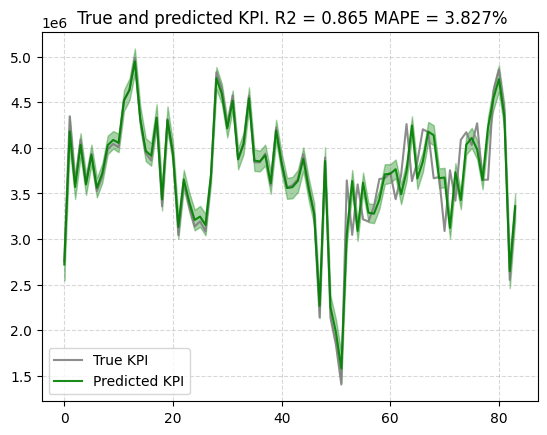

In [30]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

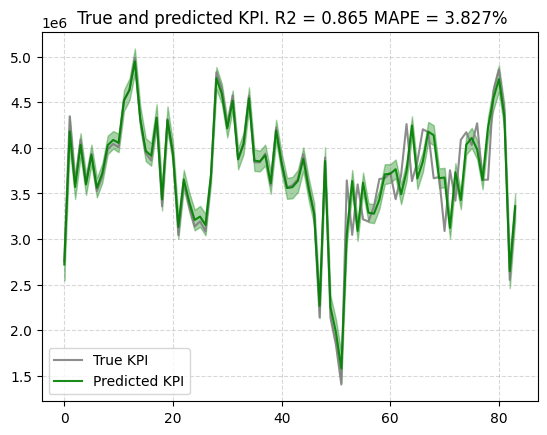

In [31]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [32]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)

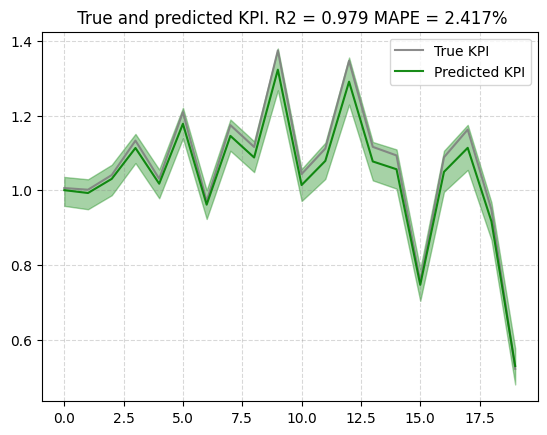

In [33]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

In [34]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

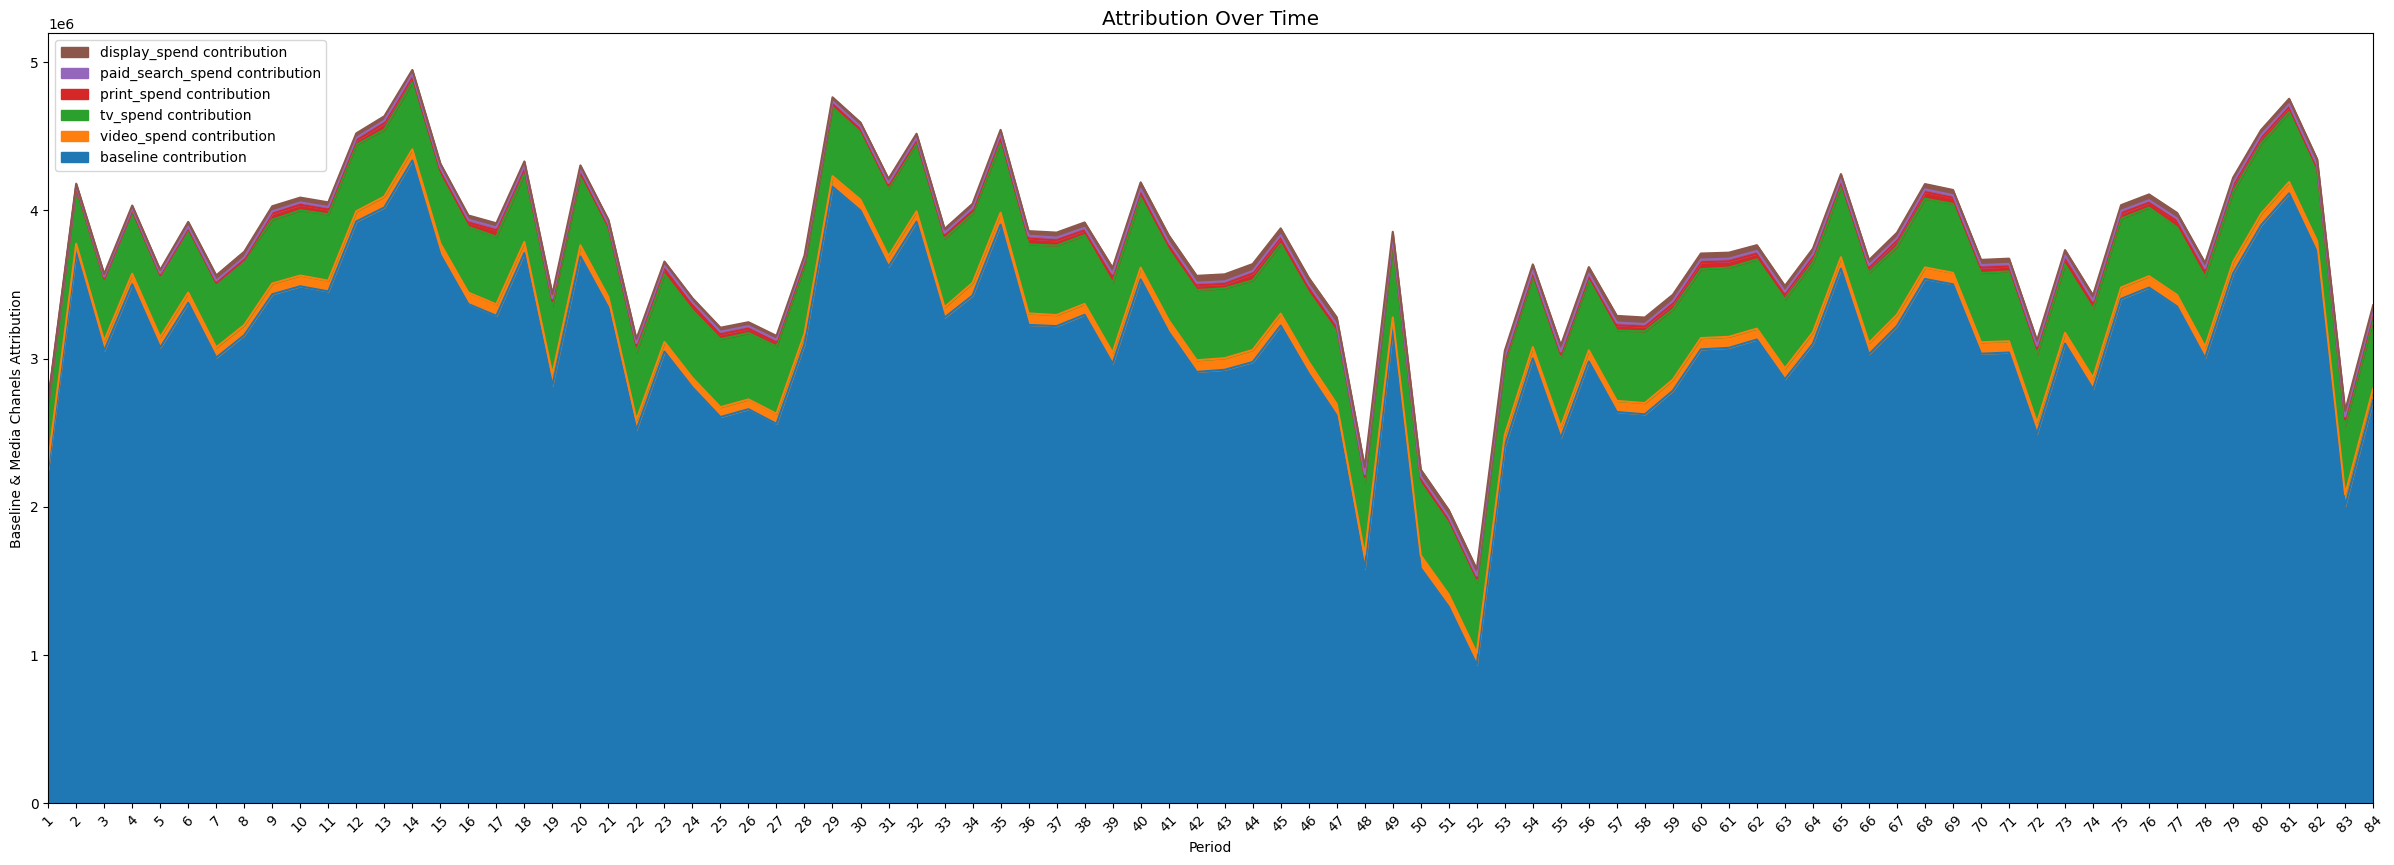

In [35]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),
                                                channel_names = media_spend_cols
                                                )
                                                

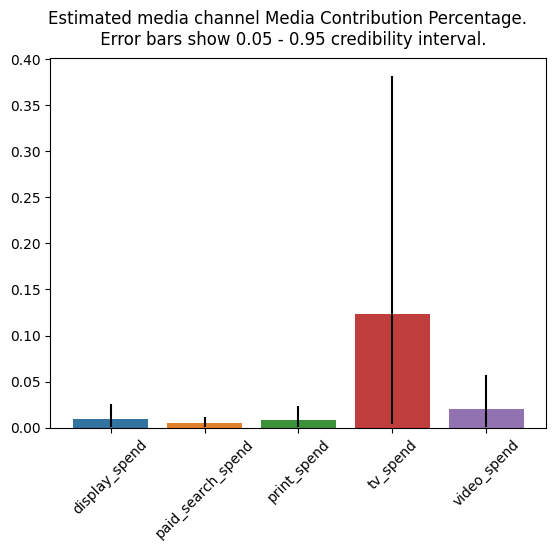

In [36]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names=media_spend_cols)

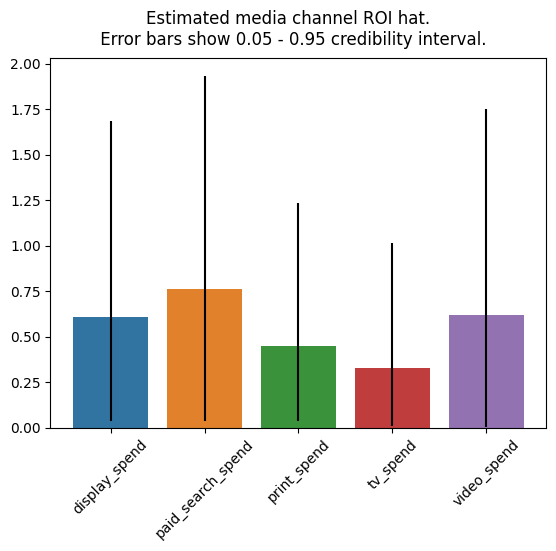

In [37]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=media_spend_cols)

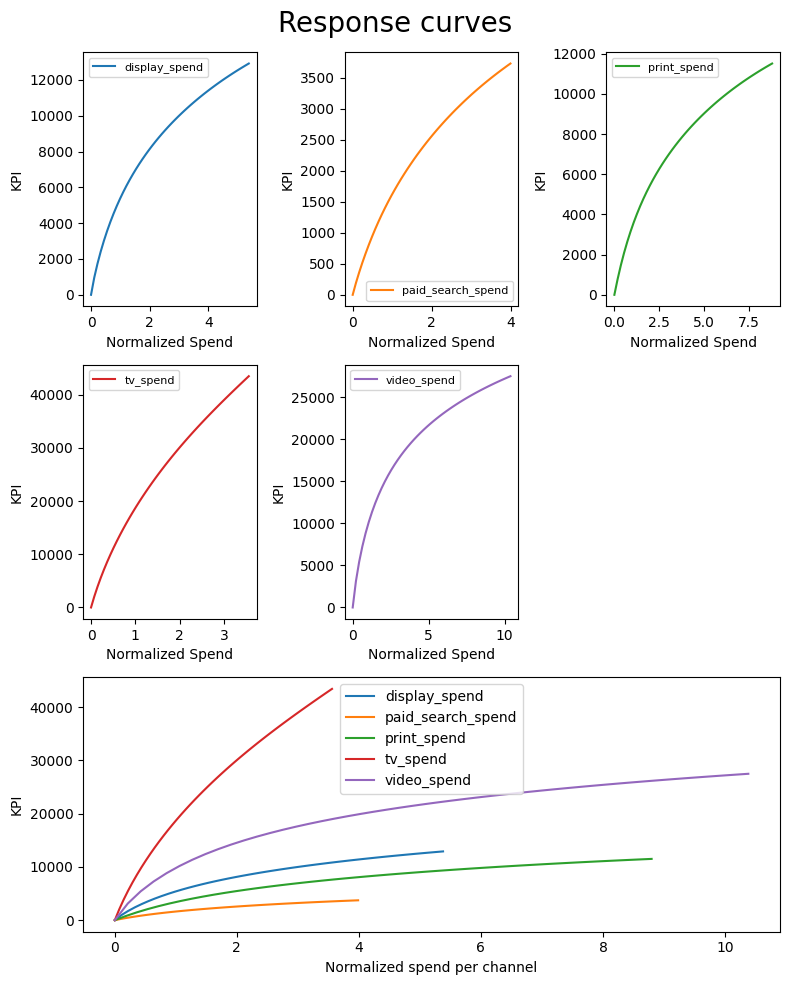

In [38]:
plot.plot_response_curves(media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

In [39]:
prices = jnp.ones(mmm.n_media_channels)
n_time_periods = 20
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    bounds_upper_pct=1.5, 
    seed=SEED)

# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

print(kpi_without_optim)
print(optimal_buget_allocation)
print(previous_budget_allocation)

In [ ]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10),
                                                channel_names = media_spend_cols)